In [10]:
import os, sys, getpass

sys.path.append(f'/home/{getpass.getuser()}/master_thesis/source/')

import glob
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
#from scripts.run_inference_mp import *
import math

In [11]:
def marginalized_llh_homogenous_mp(df_traj, params, node):
    n_states = df_traj[node].nunique()
    marg_llh = 0

    alpha_list = params[node]['alpha']
    beta_list = params[node]['beta']
    T = get_time_of_stay_in_state(df_traj, node=node)
    M = get_number_of_transitions(df_traj, node=node)
    for i in range(n_states):
        p = beta_list[i] * (T[i] + beta_list[i]) ** (M[i] + alpha_list[i]) * gamma(M[i] + alpha_list[i]) / gamma(
            alpha_list[i])
        marg_llh += np.log(p)
    return marg_llh


In [12]:
def divisors(n):
    divs = [1]
    for i in range(2, int(math.sqrt(n)) + 1):
        if n % i == 0:
            divs.extend([i, n / i])
    return np.sort(list(set(divs))).astype(int)

In [13]:
llh_0 = pd.read_csv(r"C:\Users\gizem\Desktop\DATA\roc_analysis\1592868242_5sec_200train_0test_3model_detFunctionPolicy_['particleFilter']_seed0_\psi_0\llh_particleFilter.csv", index_col=0)
llh_1 = pd.read_csv(r"C:\Users\gizem\Desktop\DATA\roc_analysis\1592868242_5sec_200train_0test_3model_detFunctionPolicy_['particleFilter']_seed0_\psi_1\llh_particleFilter.csv", index_col=0)
llh_2 = pd.read_csv(r"C:\Users\gizem\Desktop\DATA\roc_analysis\1592868242_5sec_200train_0test_3model_detFunctionPolicy_['particleFilter']_seed0_\psi_2\llh_particleFilter.csv", index_col=0)

In [23]:
llh_0 = llh_0+75
llh_1 = llh_1+75
llh_2 = llh_2+75

In [15]:
#llh_0 = pd.read_csv(r"C:\Users\gizem\Desktop\DATA\roc_analysis\1592350512_5sec_200train_0test_3model_detFunctionPolicy_['exactUpdate', 'particleFilter']_seed0_\psi_0\llh_particleFilter.csv", index_col=0)
#llh_1 = pd.read_csv(r"C:\Users\gizem\Desktop\DATA\roc_analysis\1592350512_5sec_200train_0test_3model_detFunctionPolicy_['exactUpdate', 'particleFilter']_seed0_\psi_1\llh_particleFilter.csv", index_col=0)
#llh_2 = pd.read_csv(r"C:\Users\gizem\Desktop\DATA\roc_analysis\1592350512_5sec_200train_0test_3model_detFunctionPolicy_['exactUpdate', 'particleFilter']_seed0_\psi_2\llh_particleFilter.csv", index_col=0)

In [22]:
#llh_0 = pd.read_csv(r"C:\Users\gizem\Desktop\DATA\roc_analysis\1592251084_5sec_200train_0test_3model_detFunctionPolicy_['particleFilter']_seed0_\psi_0\llh_particleFilter.csv", index_col=0)
#llh_1 = pd.read_csv(r"C:\Users\gizem\Desktop\DATA\roc_analysis\1592251084_5sec_200train_0test_3model_detFunctionPolicy_['particleFilter']_seed0_\psi_1\llh_particleFilter.csv", index_col=0)
#llh_2 = pd.read_csv(r"C:\Users\gizem\Desktop\DATA\roc_analysis\1592251084_5sec_200train_0test_3model_detFunctionPolicy_['particleFilter']_seed0_\psi_2\llh_particleFilter.csv", index_col=0)

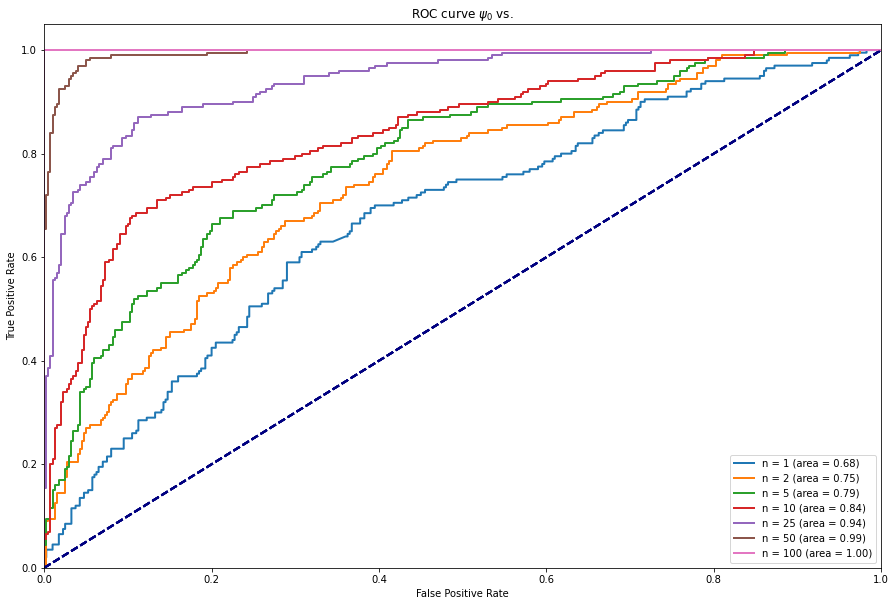

In [27]:
n_classes=3
n_sample_per_class = 200
L_list = [llh_0, llh_1, llh_2]
plt.figure(figsize=(15,10))
for n in divisors(n_sample_per_class):
    df_scores = pd.DataFrame()
    y_labels = None

    for i, df_loglh in enumerate(L_list):
        # Concatenate likelihoods from different datasets
        df_lh = np.exp(df_loglh)
        for k in range(n):
            df_shuffled_ = df_lh.sample(frac=1).reset_index(drop=True)
            df_scores = df_scores.append(df_shuffled_.groupby(df_shuffled_.index // n).mean())

        # Create and concatenate labels for different classes
        n_class_samples = int(len(df_loglh))
        y_class_labels = np.zeros((n_class_samples, n_classes))
        y_class_labels[:, i] = 1
        if y_labels is None:
            y_labels = y_class_labels
        else:
            y_labels = np.concatenate((y_labels, y_class_labels))

    df_scores.reset_index(drop=True, inplace=True)

    n_all_samples = len(df_scores)
    y_scores = df_scores.divide(df_scores.values.sum(axis=1), axis=0).values  # Normalizing likelihoods

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for m in range(n_classes):
        fpr[m], tpr[m], _ = roc_curve(y_labels[:, m], y_scores[:, m])
        roc_auc[m] = auc(fpr[m], tpr[m])

    
    if n in [1,2,5,10,25,50,100]:
        c = 2
        plt.plot(fpr[c], tpr[c],# color='darkorange',
                 lw=2, label=f'n = {n} (area = %0.2f)' % roc_auc[c])
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(r'ROC curve $\psi_{0}$ vs. ') # + f'all (n={n})')
        plt.legend(loc="lower right")
        plt.savefig(r"C:\Users\gizem\Desktop\DATA\roc_analysis\1592350512_5sec_200train_0test_3model_detFunctionPolicy_['exactUpdate', 'particleFilter']_seed0_\all_exact.png")
        # plt.show()
